# Figure 5: Adhesome genes in IMR90 and GM12878

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [2]:
# Relevant information
norm = 'GWKR'

In [3]:
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of processed HiC
dir_processed_hic_IMR90 = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_inter{norm}/'
dir_processed_hic_GM12878 = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_GM12878/final_BP250000_intraKR_inter{norm}/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

### Load useful quantities

In [4]:
# Gene to locus dictionary
with open(saving_dir+'gene2locus.pkl', 'rb') as f:
    gene2locus = pickle.load(f)
with open(saving_dir+'adhesome_locus2gene.pkl', 'rb') as f:
    adhesome_locus2gene = pickle.load(f)

In [5]:
# Blacklisted loci
with open(dir_processed_hic_IMR90+f'blacklist_IMR90_{norm}.pickle', 'rb') as f:
    blacklist_list_IMR90 = pickle.load(f)
with open(dir_processed_hic_GM12878+f'blacklist_GM12878_{norm}.pickle', 'rb') as f:
    blacklist_list_GM12878 = pickle.load(f)

### Load active/inactive genes in IMR90 and GM12878

In [6]:
# Load active/inactive genes in IMR90
with open(saving_dir+'active_genes.pkl', 'rb') as f:
    active_genes_IMR90 = pickle.load(f)
with open(saving_dir+'inactive_genes.pkl', 'rb') as f:
    inactive_genes_IMR90 = pickle.load(f)
print(f'Number of active genes in IMR90 = {len(active_genes_IMR90)}')
print(f'Number of inactive genes in IMR90 = {len(inactive_genes_IMR90)}')

Number of active genes in IMR90 = 14122
Number of inactive genes in IMR90 = 11837


In [7]:
# Load active/inactive genes in GM12878
with open(saving_dir+'active_genes_GM12878.pkl', 'rb') as f:
    active_genes_GM12878 = pickle.load(f)
with open(saving_dir+'inactive_genes_GM12878.pkl', 'rb') as f:
    inactive_genes_GM12878 = pickle.load(f)
print(f'Number of active genes in GM12878 = {len(active_genes_GM12878)}')
print(f'Number of inactive genes in GM12878 = {len(inactive_genes_GM12878)}')

Number of active genes in GM12878 = 10984
Number of inactive genes in GM12878 = 9107


### Load active/inactive adhesome genes in IMR90 and GM12878

In [8]:
# Load active/inactive genes in IMR90
with open(saving_dir+'active_adhesome_genes.pkl', 'rb') as f:
    active_adhesome_genes_IMR90 = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes.pkl', 'rb') as f:
    inactive_adhesome_genes_IMR90 = pickle.load(f)
print(f'Number of active adhesome genes in IMR90 = {len(active_adhesome_genes_IMR90)}')
print(f'Number of inactive adhesome genes in IMR90 = {len(inactive_adhesome_genes_IMR90)}')

Number of active adhesome genes in IMR90 = 202
Number of inactive adhesome genes in IMR90 = 20


In [9]:
# Load active/inactive genes in GM12878
with open(saving_dir+'active_adhesome_genes_GM12878.pkl', 'rb') as f:
    active_adhesome_genes_GM12878 = pickle.load(f)
with open(saving_dir+'inactive_adhesome_genes_GM12878.pkl', 'rb') as f:
    inactive_adhesome_genes_GM12878 = pickle.load(f)
print(f'Number of active adhesome genes in GM12878 = {len(active_adhesome_genes_GM12878)}')
print(f'Number of inactive adhesome genes in GM12878 = {len(inactive_adhesome_genes_GM12878)}')

Number of active adhesome genes in GM12878 = 172
Number of inactive adhesome genes in GM12878 = 50


### Load regulatory marks in IMR90 and GM12878

In [10]:
with open(saving_dir+'active_inactive_genes.pkl', 'rb') as f:
    df_clusters_IMR90 = pickle.load(f)

In [11]:
# Load regulatory marks in GM12878
with open(saving_dir+'active_inactive_genes_GM12878.pkl', 'rb') as f:
    df_clusters_GM12878 = pickle.load(f)

### Identify IMR90-active and GM12878-inactive adhesome genes

In [12]:
# Adhesome genes that are active in IMR90 and inactive in GM12878
selected_genes = np.array(list(set(active_adhesome_genes_IMR90).intersection(set(inactive_adhesome_genes_GM12878))))
print(f'Number of adhesome genes active in IMR90 and inactive in GM12878 = {len(selected_genes)}')
print(np.sort(selected_genes))

Number of adhesome genes active in IMR90 and inactive in GM12878 = 42
['AGAP2' 'ARHGAP32' 'ARHGAP5' 'ASAP2' 'ASAP3' 'CAV1' 'CD151' 'CORO1B'
 'CSRP1' 'DLC1' 'DOCK1' 'ENAH' 'FABP3' 'FBLIM1' 'FERMT2' 'GRB7' 'ITGA10'
 'ITGA11' 'ITGA5' 'ITGA6' 'ITGA8' 'ITGA9' 'ITGB6' 'LAYN' 'LIMS1' 'LIMS2'
 'LRP1' 'MAPK8' 'MMP14' 'NEXN' 'NRP1' 'PARVA' 'PKD1' 'PRNP' 'PTPRA'
 'PTPRH' 'RHOU' 'ROCK1' 'TGFB1I1' 'THY1' 'TNS1' 'TSPAN1']


In [14]:
# Location of selected genes
pd.set_option('max_colwidth', 400)
selected_loc = pd.DataFrame({'gene': sorted(selected_genes), 
                             'locus_id': [gene2locus[g] for g in sorted(selected_genes)]})
selected_loc.to_csv(saving_dir+'selected_negative_control_GM12878.csv', sep=';', header=True)
selected_loc

,gene,locus_id
0,AGAP2,[chr_12_loc_58000000]
1,ARHGAP32,"[chr_11_loc_128750000, chr_11_loc_129000000]"
2,ARHGAP5,[chr_14_loc_32500000]
3,ASAP2,"[chr_2_loc_9250000, chr_2_loc_9500000]"
4,ASAP3,[chr_1_loc_23750000]
5,CAV1,[chr_7_loc_116000000]
6,CD151,[chr_11_loc_750000]
7,CORO1B,[chr_11_loc_67000000]
8,CSRP1,[chr_1_loc_201250000]
9,DLC1,"[chr_8_loc_12750000, chr_8_loc_13000000, chr_8_loc_13250000]"


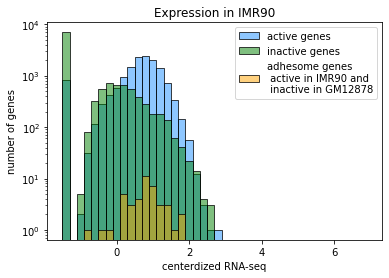

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=-1.3020012986052842, pvalue=0.19291594168065163)
Wasserstein distance (orange vs blue):
0.16521059255989956
Wilcoxon Rank-Sums test (orange vs green):
RanksumsResult(statistic=-9.07107579130472, pvalue=1.1784763855566758e-19)
Wasserstein distance (orange vs green):
1.470873389261066


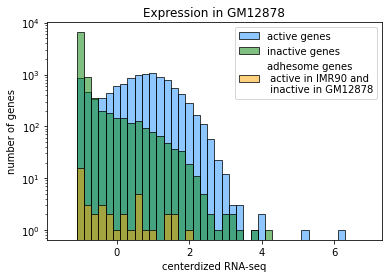

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=5.371292178619386, pvalue=7.817442600571252e-08)
Wasserstein distance (orange vs blue):
0.781103942180133
Wilcoxon Rank-Sums test (orange vs green):
RanksumsResult(statistic=-4.853958941171944, pvalue=1.2102080328262883e-06)
Wasserstein distance (orange vs green):
0.5576389250693077


In [17]:
# Check the expression of these genes in IMR90
df_clusters_IMR90['IMR90\GM12878'] = df_clusters_IMR90.index.isin(selected_genes)
plt.figure()
sns.histplot(data=df_clusters_IMR90[df_clusters_IMR90['type']=='active genes'], x='RNAseq', stat='count', alpha=0.5,
            color='dodgerblue', bins=np.arange(-1.5, 7, 0.2), 
             label='active genes')
sns.histplot(data=df_clusters_IMR90[df_clusters_IMR90['type']=='inactive genes'], x='RNAseq', stat='count', alpha=0.5,
            color='green', bins=np.arange(-1.5, 7, 0.2), 
             label='inactive genes')
sns.histplot(data=df_clusters_IMR90[df_clusters_IMR90['IMR90\GM12878']], x='RNAseq', stat='count', alpha=0.5,
             color='orange', bins=np.arange(-1.5, 7, 0.2), 
             label='adhesome genes \n active in IMR90 and \n inactive in GM12878')
plt.yscale('log')
plt.xlabel('centerdized RNA-seq')
plt.ylabel('number of genes')
plt.title('Expression in IMR90')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(df_clusters_IMR90[df_clusters_IMR90['type']=='active genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['IMR90\GM12878']]['RNAseq']))
print('Wasserstein distance (orange vs blue):')
print(ss.wasserstein_distance(df_clusters_IMR90[df_clusters_IMR90['type']=='active genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['IMR90\GM12878']]['RNAseq']))
print('Wilcoxon Rank-Sums test (orange vs green):')
print(ss.ranksums(df_clusters_IMR90[df_clusters_IMR90['type']=='inactive genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['IMR90\GM12878']]['RNAseq']))
print('Wasserstein distance (orange vs green):')
print(ss.wasserstein_distance(df_clusters_IMR90[df_clusters_IMR90['type']=='inactive genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['IMR90\GM12878']]['RNAseq']))

# Check the expression of these genes in GM12878
df_clusters_GM12878['IMR90\GM12878'] = df_clusters_GM12878.index.isin(selected_genes)
plt.figure()
sns.histplot(data=df_clusters_GM12878[df_clusters_GM12878['type']=='active genes'], x='RNAseq', stat='count', alpha=0.5,
            color='dodgerblue', bins=np.arange(-1.5, 7, 0.2), 
             label='active genes')
sns.histplot(data=df_clusters_GM12878[df_clusters_GM12878['type']=='inactive genes'], x='RNAseq', stat='count', alpha=0.5,
            color='green', bins=np.arange(-1.5, 7, 0.2), 
             label='inactive genes')
sns.histplot(data=df_clusters_GM12878[df_clusters_GM12878['IMR90\GM12878']], x='RNAseq', stat='count', alpha=0.5,
             color='orange', bins=np.arange(-1.5, 7, 0.2), 
             label='adhesome genes \n active in IMR90 and \n inactive in GM12878')
plt.yscale('log')
plt.xlabel('centerdized RNA-seq')
plt.ylabel('number of genes')
plt.title('Expression in GM12878')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(df_clusters_GM12878[df_clusters_GM12878['type']=='active genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['IMR90\GM12878']]['RNAseq']))
print('Wasserstein distance (orange vs blue):')
print(ss.wasserstein_distance(df_clusters_GM12878[df_clusters_GM12878['type']=='active genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['IMR90\GM12878']]['RNAseq']))
print('Wilcoxon Rank-Sums test (orange vs green):')
print(ss.ranksums(df_clusters_GM12878[df_clusters_GM12878['type']=='inactive genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['IMR90\GM12878']]['RNAseq']))
print('Wasserstein distance (orange vs green):')
print(ss.wasserstein_distance(df_clusters_GM12878[df_clusters_GM12878['type']=='inactive genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['IMR90\GM12878']]['RNAseq']))

### Identify IMR90-inactive and GM12878-active adhesome genes

In [18]:
# Adhesome genes that are active in GM12878 and inactive in IMR90
selected_genes2 = np.array(list(set(inactive_adhesome_genes_IMR90).intersection(set(active_adhesome_genes_GM12878))))
print(f'Number of adhesome genes inactive in IMR90 and active in GM12878 = {len(selected_genes2)}')
print(np.sort(selected_genes2))

Number of adhesome genes inactive in IMR90 and active in GM12878 = 12
['ABI3' 'CEACAM1' 'CIB2' 'INPP5D' 'ITGAL' 'ITGAM' 'ITGAX' 'ITGB4' 'MYOM1'
 'SYK' 'VAV1' 'VAV3']


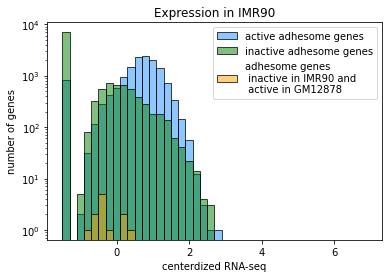

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=4.641257524834948, pvalue=3.4629521761106893e-06)
0.9267071955076595
Wilcoxon Rank-Sums test (orange vs green):
RanksumsResult(statistic=-2.2928191910882183, pvalue=0.021858416673792284)
0.5910853328151807


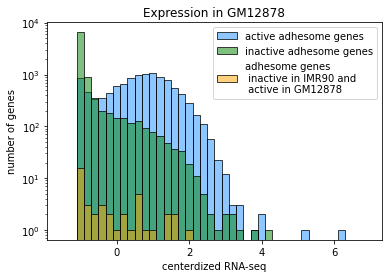

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=-1.088531194420803, pvalue=0.276360673149288)
0.28057694129127564
Wilcoxon Rank-Sums test (orange vs green):
RanksumsResult(statistic=-5.28551185074495, pvalue=1.2535375693155944e-07)
1.594797298705164


In [19]:
# Check the expression of these genes in IMR90
df_clusters_IMR90['GM12878\IMR90'] = df_clusters_IMR90.index.isin(selected_genes2)
plt.figure()
sns.histplot(data=df_clusters_IMR90[df_clusters_IMR90['type']=='active genes'], x='RNAseq', stat='count', alpha=0.5,
            color='dodgerblue', bins=np.arange(-1.5, 7, 0.2), 
             label='active adhesome genes')
sns.histplot(data=df_clusters_IMR90[df_clusters_IMR90['type']=='inactive genes'], x='RNAseq', stat='count', alpha=0.5,
            color='green', bins=np.arange(-1.5, 7, 0.2), 
             label='inactive adhesome genes')
sns.histplot(data=df_clusters_IMR90[df_clusters_IMR90['GM12878\IMR90']], x='RNAseq', stat='count', alpha=0.5,
             color='orange', bins=np.arange(-1.5, 7, 0.2), 
             label='adhesome genes \n inactive in IMR90 and \n active in GM12878')
plt.yscale('log')
plt.xlabel('centerdized RNA-seq')
plt.ylabel('number of genes')
plt.title('Expression in IMR90')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(df_clusters_IMR90[df_clusters_IMR90['type']=='active genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['GM12878\IMR90']]['RNAseq']))
print(ss.wasserstein_distance(df_clusters_IMR90[df_clusters_IMR90['type']=='active genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['GM12878\IMR90']]['RNAseq']))
print('Wilcoxon Rank-Sums test (orange vs green):')
print(ss.ranksums(df_clusters_IMR90[df_clusters_IMR90['type']=='inactive genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['GM12878\IMR90']]['RNAseq']))
print(ss.wasserstein_distance(df_clusters_IMR90[df_clusters_IMR90['type']=='inactive genes']['RNAseq'],
                  df_clusters_IMR90[df_clusters_IMR90['GM12878\IMR90']]['RNAseq']))

# Check the expression of these genes in GM12878
df_clusters_GM12878['GM12878\IMR90'] = df_clusters_GM12878.index.isin(selected_genes2)
plt.figure()
sns.histplot(data=df_clusters_GM12878[df_clusters_GM12878['type']=='active genes'], x='RNAseq', stat='count', alpha=0.5,
            color='dodgerblue', bins=np.arange(-1.5, 7, 0.2), 
             label='active adhesome genes')
sns.histplot(data=df_clusters_GM12878[df_clusters_GM12878['type']=='inactive genes'], x='RNAseq', stat='count', alpha=0.5,
            color='green', bins=np.arange(-1.5, 7, 0.2), 
             label='inactive adhesome genes')
sns.histplot(data=df_clusters_GM12878[df_clusters_GM12878['IMR90\GM12878']], x='RNAseq', stat='count', alpha=0.5,
             color='orange', bins=np.arange(-1.5, 7, 0.2), 
             label='adhesome genes \n inactive in IMR90 and \n active in GM12878')
plt.yscale('log')
plt.xlabel('centerdized RNA-seq')
plt.ylabel('number of genes')
plt.title('Expression in GM12878')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(df_clusters_GM12878[df_clusters_GM12878['type']=='active genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['GM12878\IMR90']]['RNAseq']))
print(ss.wasserstein_distance(df_clusters_GM12878[df_clusters_GM12878['type']=='active genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['GM12878\IMR90']]['RNAseq']))
print('Wilcoxon Rank-Sums test (orange vs green):')
print(ss.ranksums(df_clusters_GM12878[df_clusters_GM12878['type']=='inactive genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['GM12878\IMR90']]['RNAseq']))
print(ss.wasserstein_distance(df_clusters_GM12878[df_clusters_GM12878['type']=='inactive genes']['RNAseq'],
                  df_clusters_GM12878[df_clusters_GM12878['GM12878\IMR90']]['RNAseq']))

### Proximity of selected genes in IMR90 HiC and GM12878 HiC

In [20]:
# Loci corresponding to selected genes
selected_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in selected_genes])))
selected_loci = np.array(list(set(selected_loci)-set(blacklist_list_IMR90)))
selected_loci = selected_loci[np.argsort([int(loc.split('_')[1]) for loc in selected_loci])]

In [21]:
# Pick random genes active in IMR90 and GM12878
np.random.seed(13)
genes_pool = np.array(list(set(active_genes_IMR90).intersection(set(active_genes_GM12878))-set(selected_genes)))
loci_pool = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in genes_pool])))
loci_pool = np.array(list(set(loci_pool)-set(blacklist_list_IMR90)))
random_genes = np.random.choice(genes_pool, size=len(selected_genes), replace=False)
random_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in random_genes])))
random_loci = np.array(list(set(random_loci)-set(selected_loci)-set(blacklist_list_IMR90)))
random_loci = random_loci[np.argsort([int(loc.split('_')[1]) for loc in random_loci])]

In [22]:
# Combine selected loci and random loci
loci_list = np.concatenate([selected_loci, random_loci])

In [23]:
# Obtain Hi-C matrix of selected loci in IMR90
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic_IMR90+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df_IMR90 = contacts_df+contacts_df.T

100%|██████████| 231/231 [00:05<00:00, 39.90it/s]


In [24]:
# Obtain Hi-C contacts of all non-selected active loci in IMR90
contacts_list_IMR90 = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_pool if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_pool if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic_IMR90+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_list_IMR90.append(hic_chpair_df.loc[locus1,locus2])
with open(saving_dir+'contacts_list_IMR90.pkl', 'wb') as f:
    pickle.dump(contacts_list_IMR90, f)

100%|██████████| 231/231 [04:06<00:00,  1.07s/it]


In [25]:
# Obtain Hi-C matrix of selected loci in GM12878
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic_GM12878+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df_GM12878 = contacts_df+contacts_df.T

100%|██████████| 231/231 [00:04<00:00, 47.23it/s]


In [26]:
# Obtain Hi-C contacts of all non-selected active loci in GM12878
contacts_list_GM12878 = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_pool if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_pool if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    with open(dir_processed_hic_GM12878+processed_hic_filename, 'rb') as f:
        hic_chpair_df = pickle.load(f)

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_list_GM12878.append(hic_chpair_df.loc[locus1,locus2])
with open(saving_dir+'contacts_list_GM12878.pkl', 'wb') as f:
    pickle.dump(contacts_list_GM12878, f)

100%|██████████| 231/231 [02:36<00:00,  1.47it/s]


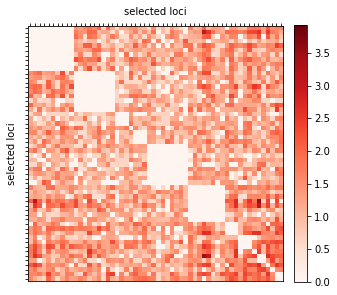

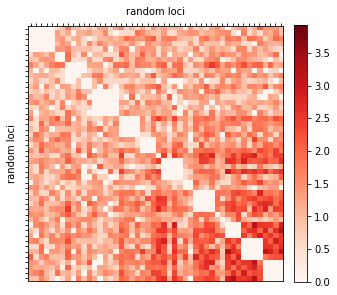

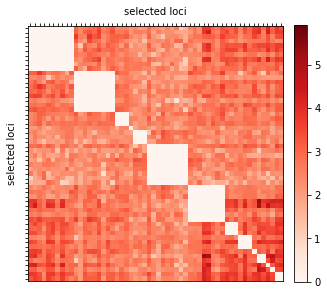

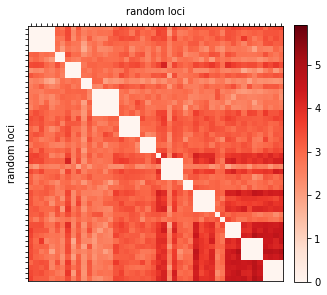

In [27]:
# Plot heatmaps
lu.plot_heatmap(contacts_df_IMR90.loc[selected_loci, selected_loci],
                ['' for _ in selected_loci], ['' for _ in selected_loci], 
                'selected loci', 'selected loci', 
                size=5, fontsize=5,
                vmax=contacts_df_IMR90.max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(contacts_df_IMR90.loc[random_loci, random_loci],
                ['' for _ in random_loci], ['' for _ in random_loci], 
                'random loci', 'random loci', 
                size=5, fontsize=5,
                vmax=contacts_df_IMR90.max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(contacts_df_GM12878.loc[selected_loci, selected_loci],
                ['' for _ in selected_loci], ['' for _ in selected_loci], 
                'selected loci', 'selected loci', 
                size=5, fontsize=5,
                vmax=contacts_df_GM12878.max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(contacts_df_GM12878.loc[random_loci, random_loci],
                ['' for _ in random_loci], ['' for _ in random_loci], 
                'random loci', 'random loci', 
                size=5, fontsize=5,
                vmax=contacts_df_GM12878.max().max(), add_patches = [],
                cmap='Reds')

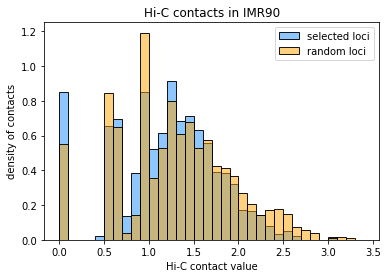

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=-3.6493750964841354, pvalue=0.0002628790196539564)


In [29]:
# Compare distributions of HiC contacts between selected and random loci in IMR90
contacts_df_IMR90_stacked = contacts_df_IMR90.stack().reset_index()
contacts_df_IMR90_stacked.columns = ['locus1', 'locus2', 'value']
contacts_df_IMR90_stacked['upper_tri'] =  (contacts_df_IMR90_stacked['locus1'].str.split('_', expand=True)[1] < contacts_df_IMR90_stacked['locus2'].str.split('_', expand=True)[1])
contacts_df_IMR90_stacked['intra_selected'] = (contacts_df_IMR90_stacked['locus1'].isin(selected_loci) & contacts_df_IMR90_stacked['locus2'].isin(selected_loci))
contacts_df_IMR90_stacked['intra_random'] = (contacts_df_IMR90_stacked['locus1'].isin(random_loci) & contacts_df_IMR90_stacked['locus2'].isin(random_loci))
IMR90_stacked_interX = contacts_df_IMR90_stacked[contacts_df_IMR90_stacked['upper_tri']]
# Plot histogram
plt.figure()
sns.histplot(data=IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']], x='value', stat='density',
             color='dodgerblue', alpha=0.5, bins=np.arange(0,3.5, 0.1),
             label='selected loci')
sns.histplot(data=IMR90_stacked_interX[IMR90_stacked_interX['intra_random']], x='value', stat='density',
             color='orange', alpha=0.5,  bins=np.arange(0,3.5, 0.1),
             label='random loci')
plt.xlabel('Hi-C contact value')
plt.ylabel('density of contacts')
plt.title('Hi-C contacts in IMR90')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']]['value'],
                  IMR90_stacked_interX[IMR90_stacked_interX['intra_random']]['value']))

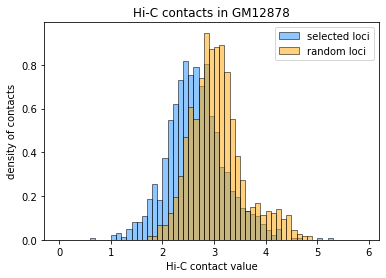

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=-18.07915743335666, pvalue=4.6513501728020275e-73)


In [30]:
# Compare distributions of HiC contacts between selected and random loci in GM12878
contacts_df_GM12878_stacked = contacts_df_GM12878.stack().reset_index()
contacts_df_GM12878_stacked.columns = ['locus1', 'locus2', 'value']
contacts_df_GM12878_stacked['upper_tri'] =  (contacts_df_GM12878_stacked['locus1'].str.split('_', expand=True)[1] < contacts_df_GM12878_stacked['locus2'].str.split('_', expand=True)[1])
contacts_df_GM12878_stacked['intra_selected'] = (contacts_df_GM12878_stacked['locus1'].isin(selected_loci) & contacts_df_GM12878_stacked['locus2'].isin(selected_loci))
contacts_df_GM12878_stacked['intra_random'] = (contacts_df_GM12878_stacked['locus1'].isin(random_loci) & contacts_df_GM12878_stacked['locus2'].isin(random_loci))
GM12878_stacked_interX = contacts_df_GM12878_stacked[contacts_df_GM12878_stacked['upper_tri']]
# Plot histogram
plt.figure()
sns.histplot(data=GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']], x='value', stat='density',
             color='dodgerblue', alpha=0.5, bins=np.arange(0,6, 0.1),
             label='selected loci')
sns.histplot(data=GM12878_stacked_interX[GM12878_stacked_interX['intra_random']], x='value', stat='density',
             color='orange', alpha=0.5, bins=np.arange(0,6, 0.1),
             label='random loci')
plt.xlabel('Hi-C contact value')
plt.ylabel('density of contacts')
plt.title('Hi-C contacts in GM12878')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']]['value'],
                  GM12878_stacked_interX[GM12878_stacked_interX['intra_random']]['value']))

In [25]:
# Load list of contacts for all non-selected active loci in IMR90 and GM12878
with open(saving_dir+'contacts_list_IMR90.pkl', 'rb') as f:
    contacts_list_IMR90 = pickle.load(f)
with open(saving_dir+'contacts_list_GM12878.pkl', 'rb') as f:
    contacts_list_GM12878 = pickle.load(f)

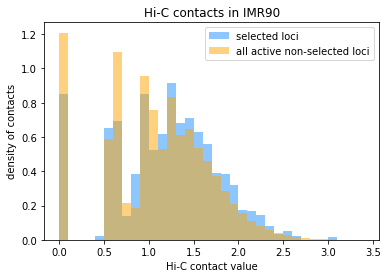

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=6.614551471360589, pvalue=1.8633998660241398e-11)


In [31]:
# Compare distributions of HiC contacts between selected and all other active loci in IMR90
plt.figure()
plt.hist(IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']]['value'],
         color='dodgerblue', alpha=0.5, bins=np.arange(0,3.5, 0.1), density=True,
         label='selected loci')
plt.hist(contacts_list_IMR90,
         color='orange', alpha=0.5, bins=np.arange(0,3.5, 0.1), density=True,
         label='all active non-selected loci')
plt.xlabel('Hi-C contact value')
plt.ylabel('density of contacts')
plt.title('Hi-C contacts in IMR90')
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']]['value'],
                  contacts_list_IMR90, alternative='greater'))

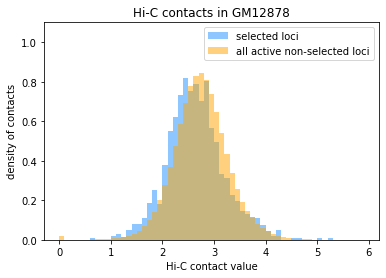

Wilcoxon Rank-Sums test (orange vs blue):
RanksumsResult(statistic=-8.275618415163292, pvalue=6.389531374277478e-17)


In [33]:
# Compare distributions of HiC contacts between selected and all other active loci in GM12878
plt.figure()
plt.hist(GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']]['value'],
         color='dodgerblue', alpha=0.5, density=True, bins=np.arange(0,6, 0.1),
         label='selected loci')
plt.hist(contacts_list_GM12878,
         color='orange', alpha=0.5, density=True, bins=np.arange(0,6, 0.1),
         label='all active non-selected loci')
plt.xlabel('Hi-C contact value')
plt.ylabel('density of contacts')
plt.title('Hi-C contacts in GM12878')
plt.ylim(0,1.1)
plt.legend(loc='upper right')
plt.show()
print('Wilcoxon Rank-Sums test (orange vs blue):')
print(ss.ranksums(GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']]['value'],
                  contacts_list_GM12878, alternative='less'))

In [29]:
# We identify edges in the upper 25th percentile of IMR90 and the lower 25th percentile of GM12878
thresh = 0.10
IMR90_pctile = np.quantile(IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']]['value'].values, 
                           1-thresh)
GM12878_pctile = np.quantile(GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']]['value'].values, 
                             thresh)

df1 = IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']].set_index(['locus1', 'locus2'])[['value']]
df2 = GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']].set_index(['locus1', 'locus2'])[['value']]
df_combined = df1.join(df2, how='inner', lsuffix='_IMR90', rsuffix='_GM12878')
df_combined = df_combined.reset_index()

selected_edges = df_combined[(df_combined['value_IMR90']>IMR90_pctile) & 
                             (df_combined['value_GM12878']<GM12878_pctile)]
selected_edges['genes1'] = [adhesome_locus2gene[loc] for loc in selected_edges['locus1']]
selected_edges['genes2'] = [adhesome_locus2gene[loc] for loc in selected_edges['locus2']]
selected_edges = selected_edges[['genes1', 'genes2', 'value_IMR90', 'value_GM12878']]
selected_edges = lu.unnesting(selected_edges, ['genes1'])
selected_edges = lu.unnesting(selected_edges, ['genes2'])
selected_edges.columns = ['gene1', 'gene2', 'hic_IMR90', 'hic_GM12878']
selected_edges

,gene1,gene2,hic_IMR90,hic_GM12878
25,PARVA,TSPAN1,1.723862,1.854292
105,DLC1,RHOU,2.038482,1.520779
388,NRP1,ASAP3,1.669675,1.812640
434,NRP1,NEXN,2.185475,1.736628
662,PKD1,NRP1,1.752855,1.982888
716,CAV1,NRP1,1.674170,1.922996
872,LAYN,DOCK1,1.709284,1.555830
930,CAV1,THY1,1.786048,1.573901


In [30]:
np.unique(np.concatenate([selected_edges['gene1'].values, selected_edges['gene2'].values]))

array(['ASAP3', 'CAV1', 'DLC1', 'DOCK1', 'LAYN', 'NEXN', 'NRP1', 'PARVA',
       'PKD1', 'RHOU', 'THY1', 'TSPAN1'], dtype=object)

[]

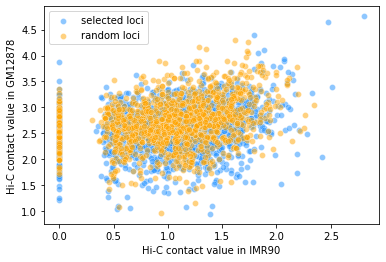

In [31]:
# Compare HiC value of selected loci in IMR90 ad GM12878
df1 = IMR90_stacked_interX[IMR90_stacked_interX['intra_selected']].set_index(['locus1', 'locus2'])[['value']]
df2 = GM12878_stacked_interX[GM12878_stacked_interX['intra_selected']].set_index(['locus1', 'locus2'])[['value']]
df_combined = df1.join(df2, how='inner', lsuffix='_IMR90', rsuffix='_GM12878')
df_combined = df_combined.reset_index()

df1 = IMR90_stacked_interX[IMR90_stacked_interX['intra_random']].set_index(['locus1', 'locus2'])[['value']]
df2 = GM12878_stacked_interX[GM12878_stacked_interX['intra_random']].set_index(['locus1', 'locus2'])[['value']]
df_combined2 = df1.join(df2, how='inner', lsuffix='_IMR90', rsuffix='_GM12878')
df_combined2 = df_combined2.reset_index()

plt.figure()
sns.scatterplot(data = df_combined, x='value_IMR90', y='value_GM12878', color='dodgerblue', alpha=0.5,
                label='selected loci')
sns.scatterplot(data = df_combined2, x='value_IMR90', y='value_GM12878', color='orange', alpha=0.5,
                label='random loci')
plt.xlabel('Hi-C contact value in IMR90')
plt.ylabel('Hi-C contact value in GM12878')
plt.legend(loc='upper left')
plt.plot()